In [50]:
import netCDF4 as nc
import numpy as np
def readDBabse(nclass,fname,n5):
    with nc.Dataset(fname) as fh:
        zkum=fh.variables["zkum%2.2i"%nclass][:,:-n5]
        zkam=fh.variables["zkam%2.2i"%nclass][:,:-n5]
        pRate=fh.variables["pRate%2.2i"%nclass][:,:-n5]
        pRate=fh.variables["pRate%2.2i"%nclass][:,:-n5]
        n52=int(n5/2)
        pRateCMB=fh.variables["pRateCMB%2.2i"%nclass][:,:-n52]
    zkum[zkum<0]=0
    FL=168+2*nclass
    return zkum,zkam,pRate,pRateCMB,FL

fnameO="stratiformProfilesOcean.nc"
fnameL="stratiformProfiles_2.nc"

ncl=2

zkumO,zkamO,pRateO,pRateCMBO,FL_O=readDBabse(ncl,fnameL,6)



In [32]:
print(pRateCMBO.shape)

(136518, 40)


(129647, 40)
(40,)


(20.0, -40.0)

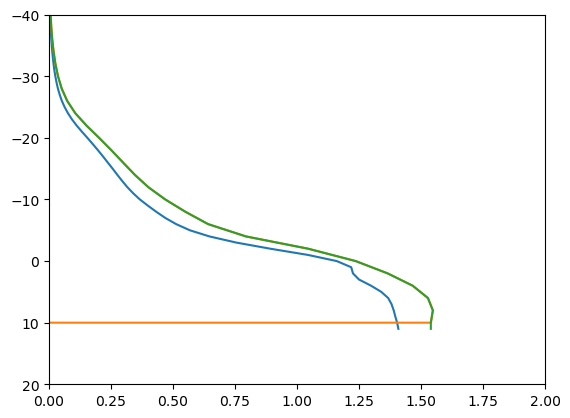

In [51]:
zkumO[0,77]
import matplotlib.pyplot as plt
h=np.arange(zkumO.shape[1])+2*ncl-70
print(pRateCMBO.shape)
print(h[::2].shape)
plt.plot(pRateO.mean(axis=0)[0:78],h[0:78])
plt.plot(pRateCMBO.mean(axis=0),h[0::2])
pRateCMBOResampled=np.interp(h[0:78],h[0::2][:-1],pRateCMBO.mean(axis=0)[:-1])
plt.plot(pRateCMBOResampled,h[0:78])
plt.xlim(0,2)
plt.ylim(20,-40)


In [67]:
xL=[]
yL=[]
corrCoefL=[]
relBiasL=[]
clut_unrolled_L=[]
classL=[]
npoints=15
for ncl in range(1,2):
    print(ncl)
    zkumO,zkamO,pRateO,pRateCMBO,FL_O=readDBabse(ncl,fnameL,6)
    zkumO=zkumO[:,:78]
    pRateO=pRateO[:,:78]   
    pRateCMBO=pRateCMBO[:,:39] 
#print(zkumO.shape)
    h=np.arange(zkumO.shape[1])+2*ncl-70
#print(h)
    zmL=[]
    hL=[]
    pRateL=[]
    pRateLL=[]
    indL=[]
    clutL=[]
    for it in range(3):
        for i,zkum in enumerate(zkumO):
            k=np.random.randint(0,25)
            nlev_end=k+1
            nlev_start=nlev_end+npoints
            hL.append(h[-nlev_start:-nlev_end])
            zmL.append(zkum[-nlev_start:-nlev_end])
            pRateCMBO_Resampled=np.interp(h[0:78],h[0::2][:-1],pRateCMBO[i,:][:-1])
            pRateLL.append(pRateCMBO_Resampled[-nlev_end-1])
            pRateL.append(pRateCMBO_Resampled[-1])
            x1=[]
            x1.extend(zmL[-1])
            x1.extend(hL[-1])
            x1.append(pRateLL[-1])
            yL.append(pRateL[-1])
            indL.append(h[-1])
            clutL.append(k)
            xL.append(x1)
            classL.append(ncl)
    pRateLL=np.array(pRateLL)
    pRateL=np.array(pRateL)
    clutL=np.array(clutL)
    corrCoef=[]
    relBias=[]
    clut_unrolled_L.append(clutL)
    for i in range(25):
        a=np.where(clutL==i)
        corrCoef.append(np.corrcoef(pRateLL[a],pRateL[a])[0,1])
        relBias.append((pRateLL[a].mean()-pRateL[a].mean())/pRateL[a].mean())
    corrCoefL.append(corrCoef)
    relBiasL.append(relBias)

1


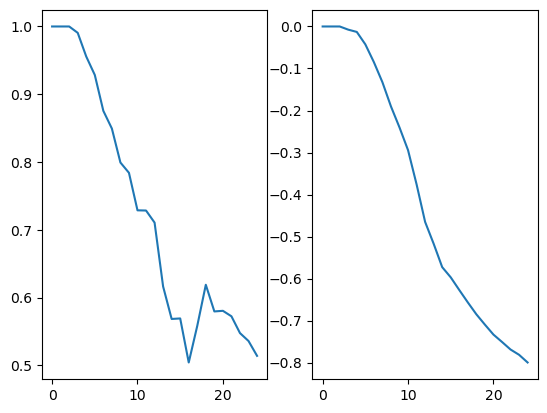

In [68]:
plt.subplot(121)
plt.plot(corrCoef)
plt.subplot(122)
plt.plot(relBias)

In [9]:
# import knn regression from sklearn
from sklearn.neighbors import KNeighborsRegressor
# create knn model
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
# split the data into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, ind_train, ind_test = train_test_split(xL, range(len(xL)), test_size=0.2, random_state=42)
# fit the model
y_train=[pRateL[i] for i in ind_train]
y_test=[pRateL[i] for i in ind_test]
knn.fit(X_train, y_train)
# predict the response
pred = knn.predict(X_test)
# evaluate accuracy
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_test, pred))
print(np.corrcoef(y_test, pred))
print(np.mean(y_test),np.mean(pred))

1.6724415349051736
[[1.         0.67689384]
 [0.67689384 1.        ]]
1.3337092 1.3059612224254142


In [11]:
print(np.corrcoef(pRateLL,pRateL))
print(np.mean(pRateLL),np.mean(pRateL))
X_test=np.array(X_test)
X_train=np.array(X_train)
print(X_test.mean(axis=0))
print(X_train.shape)

[[1.         0.66708115]
 [0.66708115 1.        ]]
0.75178397 1.3419697
[ 14.09809552  14.8351996   15.51892324  16.13359251  16.69054021
  17.23113244  17.76628736  18.30832332  18.75131996  19.20510145
 -13.00369909 -12.00369909 -11.00369909 -10.00369909  -9.00369909
  -8.00369909  -7.00369909  -6.00369909  -5.00369909  -4.00369909
   0.74388075]
(109214, 21)


In [12]:
# define a tensorflow model with 2 hidden layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import activations
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K

def tf_model():
    model = keras.Sequential()
    model.add(Dense(32, input_dim=21, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    return model

# create a model
model = tf_model()
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                704       
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,793
Trainable params: 1,793
Non-trainable params: 0
_________________________________________________________________
None


NameError: name 'X_train_scaled' is not defined

In [13]:

# normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
model(X_train_scaled)
y_test=np.array(y_test)[:,np.newaxis]
y_train=np.array(y_train)[:,np.newaxis]


In [14]:

# fit the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test_scaled, y_test))

Epoch 1/100


2023-07-07 21:15:06.840259: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3413/3413 [==============================] - 2s 506us/step - loss: 1.5032 - mse: 1.5032 - mae: 0.6373 - val_loss: 1.4454 - val_mse: 1.4454 - val_mae: 0.6007
Epoch 2/100
3413/3413 [==============================] - 2s 480us/step - loss: 1.3960 - mse: 1.3960 - mae: 0.6147 - val_loss: 1.4335 - val_mse: 1.4335 - val_mae: 0.5951
Epoch 3/100
3413/3413 [==============================] - 2s 472us/step - loss: 1.3782 - mse: 1.3782 - mae: 0.6119 - val_loss: 1.4062 - val_mse: 1.4062 - val_mae: 0.6173
Epoch 4/100
3413/3413 [==============================] - 2s 481us/step - loss: 1.3646 - mse: 1.3646 - mae: 0.6078 - val_loss: 1.3826 - val_mse: 1.3826 - val_mae: 0.5944
Epoch 5/100
3413/3413 [==============================] - 2s 477us/step - loss: 1.3522 - mse: 1.3522 - mae: 0.6073 - val_loss: 1.4035 - val_mse: 1.4035 - val_mae: 0.5857
Epoch 6/100
3413/3413 [==============================] - 2s 480us/step - loss: 1.3401 - mse: 1.3401 - mae: 0.6041 - val_loss: 1.3765 - val_mse: 1.3765 - val_mae: 0.603

In [15]:
y_pred = model.predict(X_test_scaled)
#y_test=np.array(y_test)[:,np.newaxis]
print(np.corrcoef(y_test[:,0], y_pred[:,0]))
print(np.corrcoef(y_test[:,0], [pRateLL[i] for i in ind_test]))
#print(np.mean(y_test),np.mean(y_pred))
print(h[0])

854/854 [==============================] - 0s 278us/step
[[1.         0.76477767]
 [0.76477767 1.        ]]
[[1.         0.66307327]
 [0.66307327 1.        ]]
-68
